In [21]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

### Constants

In [22]:
# Mass
m = 0.044

# Principle moments of inertia
J_y = 1.60e-05

# Acceleration of gravity
g = 9.81

# Pendulum parameters
l_pen = 150e-3 # maybe m
m_pen = 0.006

# state: [o_x, o_x_dot, o_z, o_z_dot, theta, theta_dot, alpha, alpha_dot]

# inputs: [tau_y, f_z]

### State Derivative

Calculates the derivative of the state.

In [23]:
def propogate_state(state, inputs):
    state_dot = np.zeros(8)
    state_dot[0] = state[1]
    state_dot[1] = (-inputs[1]*m_pen*np.sin(state[6] - state[4])*np.cos(state[6]) + m*(state[7]**2 * l_pen * m_pen * np.sin(state[6]) + inputs[1]*np.sin(state[4])))/(m*(m+m_pen))
    state_dot[2] = state[3]
    state_dot[3] = (inputs[1]*m_pen*np.sin(state[6] - state[4])*np.sin(state[6]) + m*(state[7]**2 * l_pen * m_pen * np.cos(state[6]) + inputs[1]*np.cos(state[4]) - g*m - g*m_pen))/(m*(m+m_pen))
    state_dot[4] = state[5]
    state_dot[5] = inputs[0]/J_y
    state_dot[6] = state[7]
    state_dot[7] = inputs[1]*np.sin(state[6] - state[4])/(l_pen*m)
    return state_dot

### RK4 propogator

To get the next state

In [24]:
def rk4(state, inputs, delta_t):
    y1 = propogate_state(state, inputs)
    y2 = propogate_state(state + 1/2*delta_t*y1, inputs)
    y3 = propogate_state(state + 1/2*delta_t*y2, inputs)
    y4 = propogate_state(state + delta_t*y3, inputs)

    return state + 1/6 * delta_t *(y1 + 2*y2 + 2*y3 + y4)


### Controller

To calculate the inputs based on the current state. The K values are from the `planar_problem_state_space.ipynb` notebook.

In [25]:
def controller(state, state_des):
    K = np.array([[-3.16227766e-04, -5.62372285e-04, -3.75118589e-18,
        -3.58037631e-18,  1.18799716e-02,  6.92935127e-04,
        -1.52344145e-02, -1.80434720e-03],
       [ 2.70362764e-15,  2.30331138e-15,  3.16227766e-01,
         3.62798534e-01, -4.13236788e-14, -1.14572042e-15,
         6.80987900e-14,  7.57825355e-15]])
    u = -K @ (state - state_des)
    u[1] += (m + m_pen)*g
    return u

Run the sim

In [26]:
def sim(times,inputs_data, state_data, state_des, delta_t):
    for i, time in enumerate(times):

        if i == 0:
            continue

        else:
            inputs_data[i-1] = controller(state_data[i-1], state_des)
            state_data[i] = rk4(state_data[i-1], inputs_data[i-1], delta_t)

In [27]:
# Set up sim
delta_t = 0.01
total_t = 10
times = np.arange(0, total_t + delta_t/2, delta_t)
inputs_data = np.zeros((len(times), 2))
state_data = np.zeros((len(times), 8))

# Desired States
state_des = np.array([0., 0., 3.0, 0., 0., 0., 0., 0.])
# Initial condition
state_data[0] = np.array([0.2, 0., 3.0, 0., 0., 0., 0.4, 0.])

# Run sim
sim(times, inputs_data, state_data, state_des, delta_t)

### Plotting and animation

Text(0.5, 0, 'time (s)')

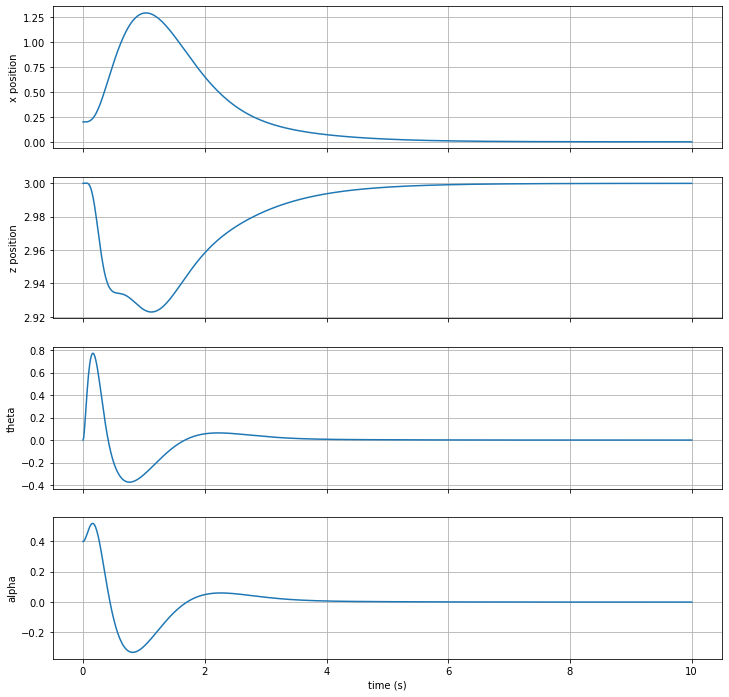

In [28]:
fig, (ax_o_x, ax_o_z, ax_theta, ax_alpha) = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

ax_o_x.plot(times, state_data[:,0])
ax_o_x.set_ylabel('x position')
ax_o_z.plot(times, state_data[:,2])
ax_o_z.set_ylabel('z position')
ax_theta.plot(times, state_data[:,4])
ax_theta.set_ylabel('theta')
ax_alpha.plot(times, state_data[:,6])
ax_alpha.set_ylabel('alpha')
ax_o_x.grid()
ax_o_z.grid()
ax_theta.grid()
ax_alpha.grid()
ax_alpha.set_xlabel('time (s)')

Text(0.5, 17.200000000000003, 'time (s)')

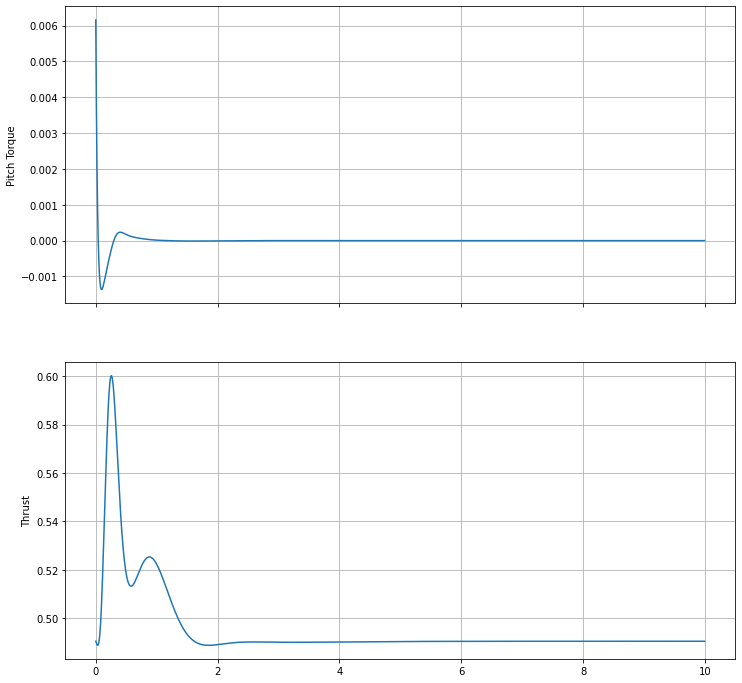

In [29]:
fig, (ax_tau_y, ax_f_z) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

ax_tau_y.plot(times[:-1], inputs_data[:-1,0])
ax_f_z.plot(times[:-1], inputs_data[:-1,1])
ax_tau_y.set_ylabel('Pitch Torque')
ax_f_z.set_ylabel('Thrust')
ax_tau_y.grid()
ax_f_z.grid()
ax_alpha.set_xlabel('time (s)')

In [30]:
# Write State Data and Timestamps to a csv for Animation

import os

record = []
for point in range(len(times)):
    cur_point = []
    cur_point.append(str(times[point]))
    cur_point.append(str(state_data[point, 0])) #x-pos
    cur_point.append(str(state_data[point, 2])) #z-pos
    cur_point.append(str(state_data[point, 4])) #theta
    cur_point.append(str(state_data[point,6]))  #alpha
    record.append(cur_point)
print(state_data[13, 6])
output_file = 'sim.csv'
with open(output_file, 'w') as f:
    f.write("time,x,z,theta,alpha\n")
    for point in record:
        f.write(f"{','.join(point)}\n")

0.510842030082037
